In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
print(tf.__version__)

2024-02-04 17:37:26.115290: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 17:37:26.115382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 17:37:26.272395: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Num GPUs: 2


In [5]:
import numpy as np
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid',palette='muted', font_scale=1.5)

In [6]:
rcParams['figure.figsize']=22,10

RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)

In [7]:
df=pd.read_csv('/kaggle/input/sp500-daily-19862018/spx.csv', parse_dates=['date'], index_col='date')

/tmp/ipykernel_34/2386026626.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df=pd.read_csv('/kaggle/input/sp500-daily-19862018/spx.csv', parse_dates=['date'], index_col='date')


In [8]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


In [9]:
df.shape

(8192, 1)

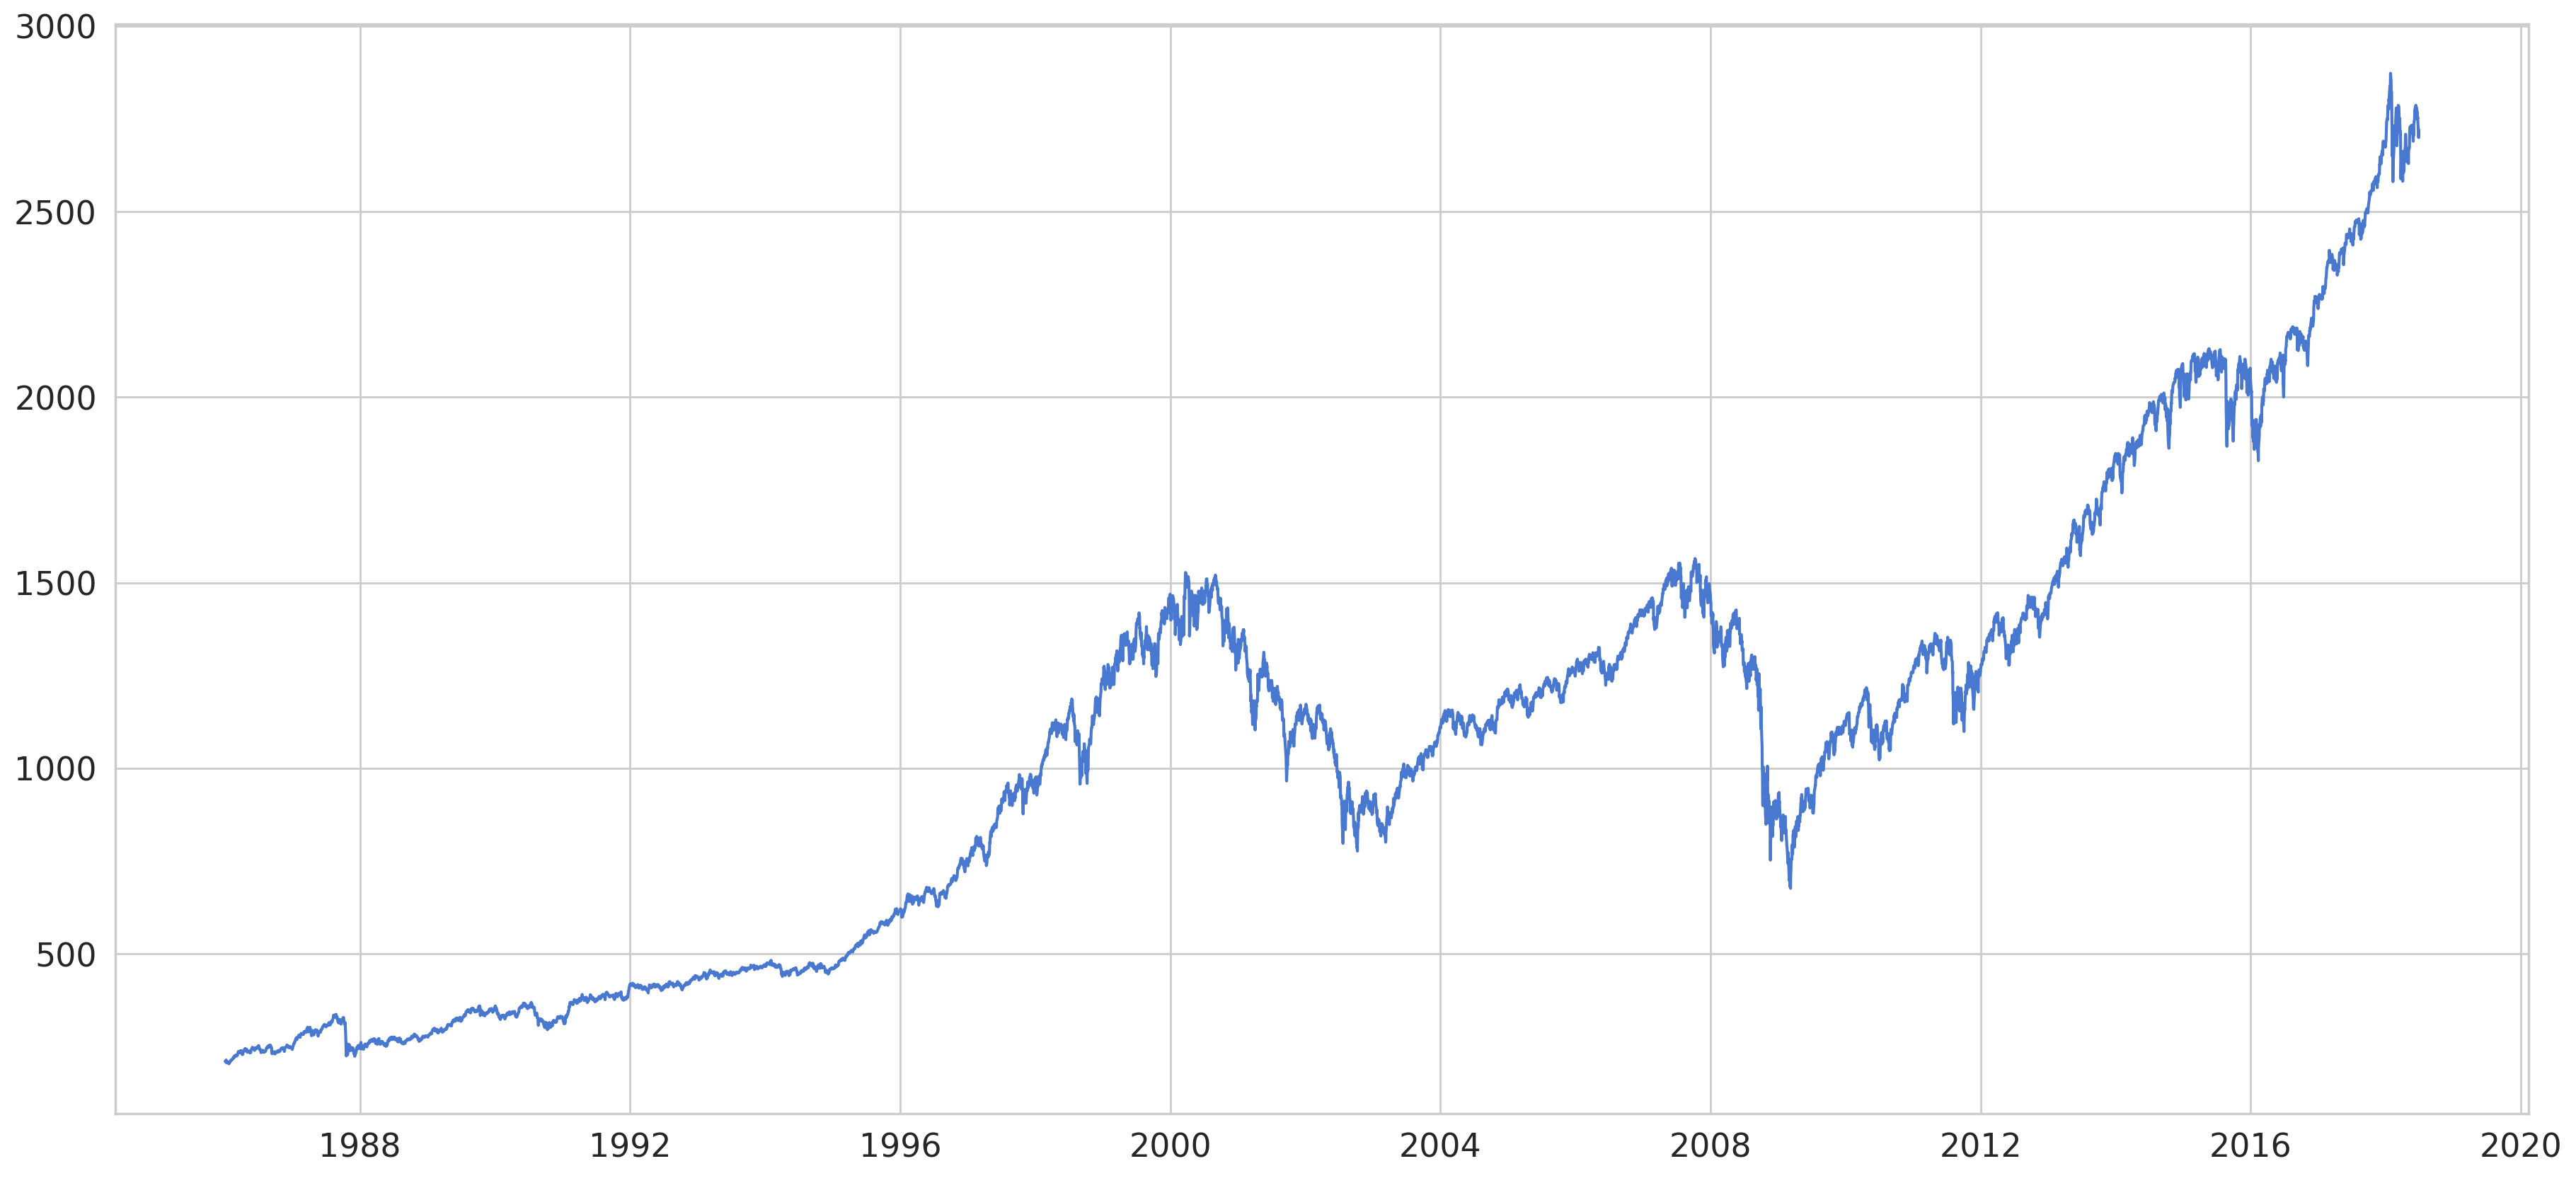

In [10]:
plt.plot(df,label='close');

In [11]:
train_size=int(len(df)*0.95)
test_size=len(df)-train_size
train,test=df.iloc[0:train_size],df.iloc[train_size:len(df)]
print(train.shape,test.shape)

(7782, 1) (410, 1)


In [12]:
train,test=df.iloc[0:train_size],df.iloc[train_size:len(df)]
print(train.shape,test.shape)

(7782, 1) (410, 1)


In [14]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler=scaler.fit(train[['close']])

In [15]:
train['close']=scaler.transform(train[['close']])
test['close']=scaler.transform(test[['close']])

/tmp/ipykernel_34/1272241854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close']=scaler.transform(train[['close']])
/tmp/ipykernel_34/1272241854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close']=scaler.transform(test[['close']])


In [16]:
train.head()

,close
date,
1986-01-02,-1.475126
1986-01-03,-1.472703
1986-01-06,-1.473135
1986-01-07,-1.467219
1986-01-08,-1.478169


In [17]:
def create_dataset(x,y,time_steps=1):
  xs,ys=[],[]
  for i in range(len(x)-time_steps):
    v=x.iloc[i:(i+time_steps)].values
    xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(xs), np.array(ys)


In [18]:
TIME_STEPS=30
x_train,y_train=create_dataset(train[['close']],train.close,TIME_STEPS)
x_test,y_test=create_dataset(test[['close']],test.close,TIME_STEPS)


In [19]:
x_train.shape

(7752, 30, 1)

In [20]:
#LSTM Autoencoder

model=keras.Sequential()
model.add(keras.layers.LSTM
(
    units=64,input_shape=(x_train.shape[1],x_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=x_train.shape[1]))
model.add(keras.layers.LSTM
(
    units=64,
    return_sequences=True
))

model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(
    units=x_train.shape[2]
)))

model.compile(loss='mae',optimizer='adam')

In [21]:
history=model.fit(
    x_train,y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10


I0000 00:00:1707068690.486543     175 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


218/218 [==============================] - 7s 10ms/step - loss: 0.1836 - val_loss: 0.2983
Epoch 2/10
218/218 [==============================] - 1s 6ms/step - loss: 0.1032 - val_loss: 0.2404
Epoch 3/10
218/218 [==============================] - 1s 6ms/step - loss: 0.1059 - val_loss: 0.2383
Epoch 4/10
218/218 [==============================] - 1s 6ms/step - loss: 0.1294 - val_loss: 0.2465
Epoch 5/10
218/218 [==============================] - 1s 6ms/step - loss: 0.1353 - val_loss: 0.2886
Epoch 6/10
218/218 [==============================] - 1s 7ms/step - loss: 0.1168 - val_loss: 0.3438
Epoch 7/10
218/218 [==============================] - 1s 6ms/step - loss: 0.1141 - val_loss: 0.3171
Epoch 8/10
218/218 [==============================] - 1s 6ms/step - loss: 0.1182 - val_loss: 0.2127
Epoch 9/10
218/218 [==============================] - 1s 6ms/step - loss: 0.1124 - val_loss: 0.2134
Epoch 10/10
218/218 [==============================] - 1s 6ms/step - loss: 0.1280 - val_loss: 0.2067


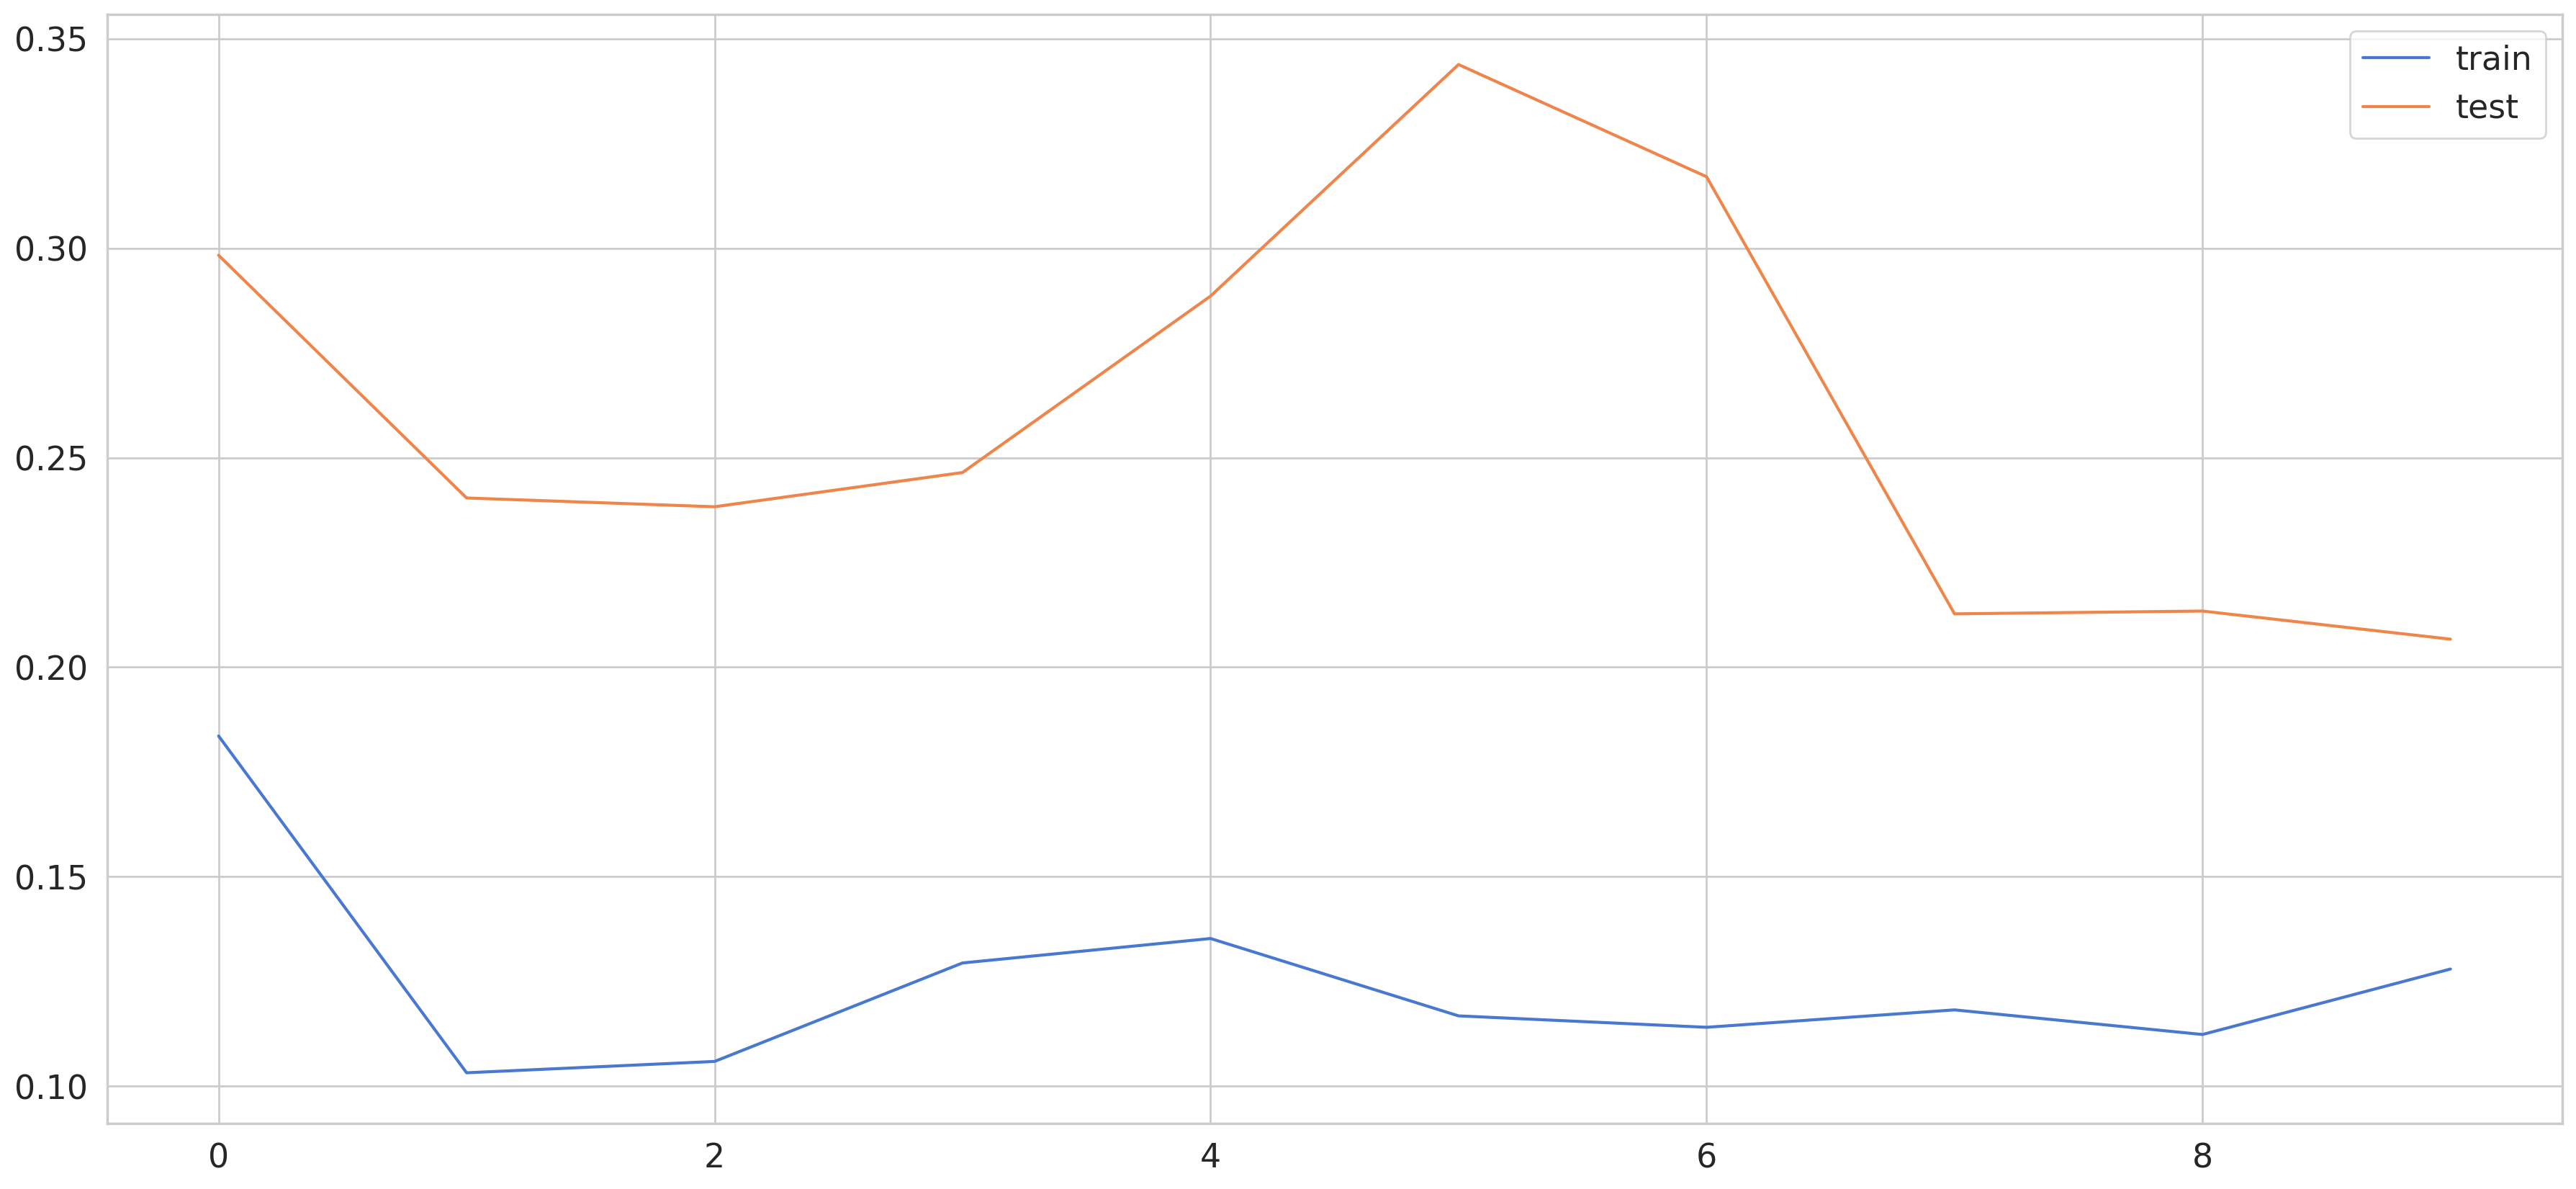

In [22]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend();

In [23]:
x_train_pred=model.predict(x_train)

243/243 [==============================] - 1s 3ms/step


In [24]:
train_mae_loss=np.mean(np.abs(x_train_pred,x_train),axis=1)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


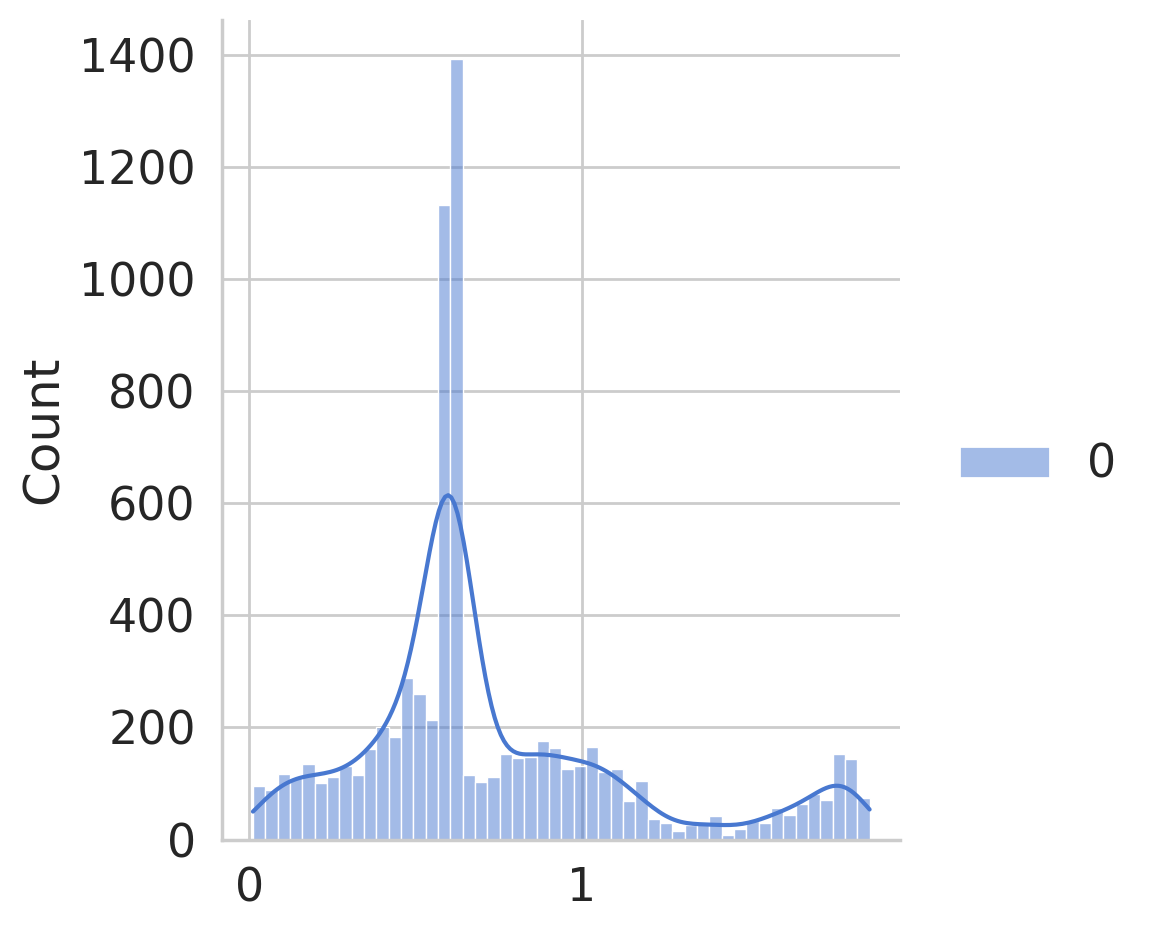

In [25]:
sns.displot(train_mae_loss,bins=50,kde=True);

In [26]:
x_test_pred=model.predict(x_test)
test_mae_loss=np.mean(np.abs(x_test_pred,x_test),axis=1)

12/12 [==============================] - 0s 3ms/step


In [27]:
THRESHOLD=0.95
test_score_df=pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss']=test_mae_loss
test_score_df['threshold']=THRESHOLD
test_score_df['anomaly']=test_score_df.loss>test_score_df.threshold
test_score_df['close']=test[TIME_STEPS:].close

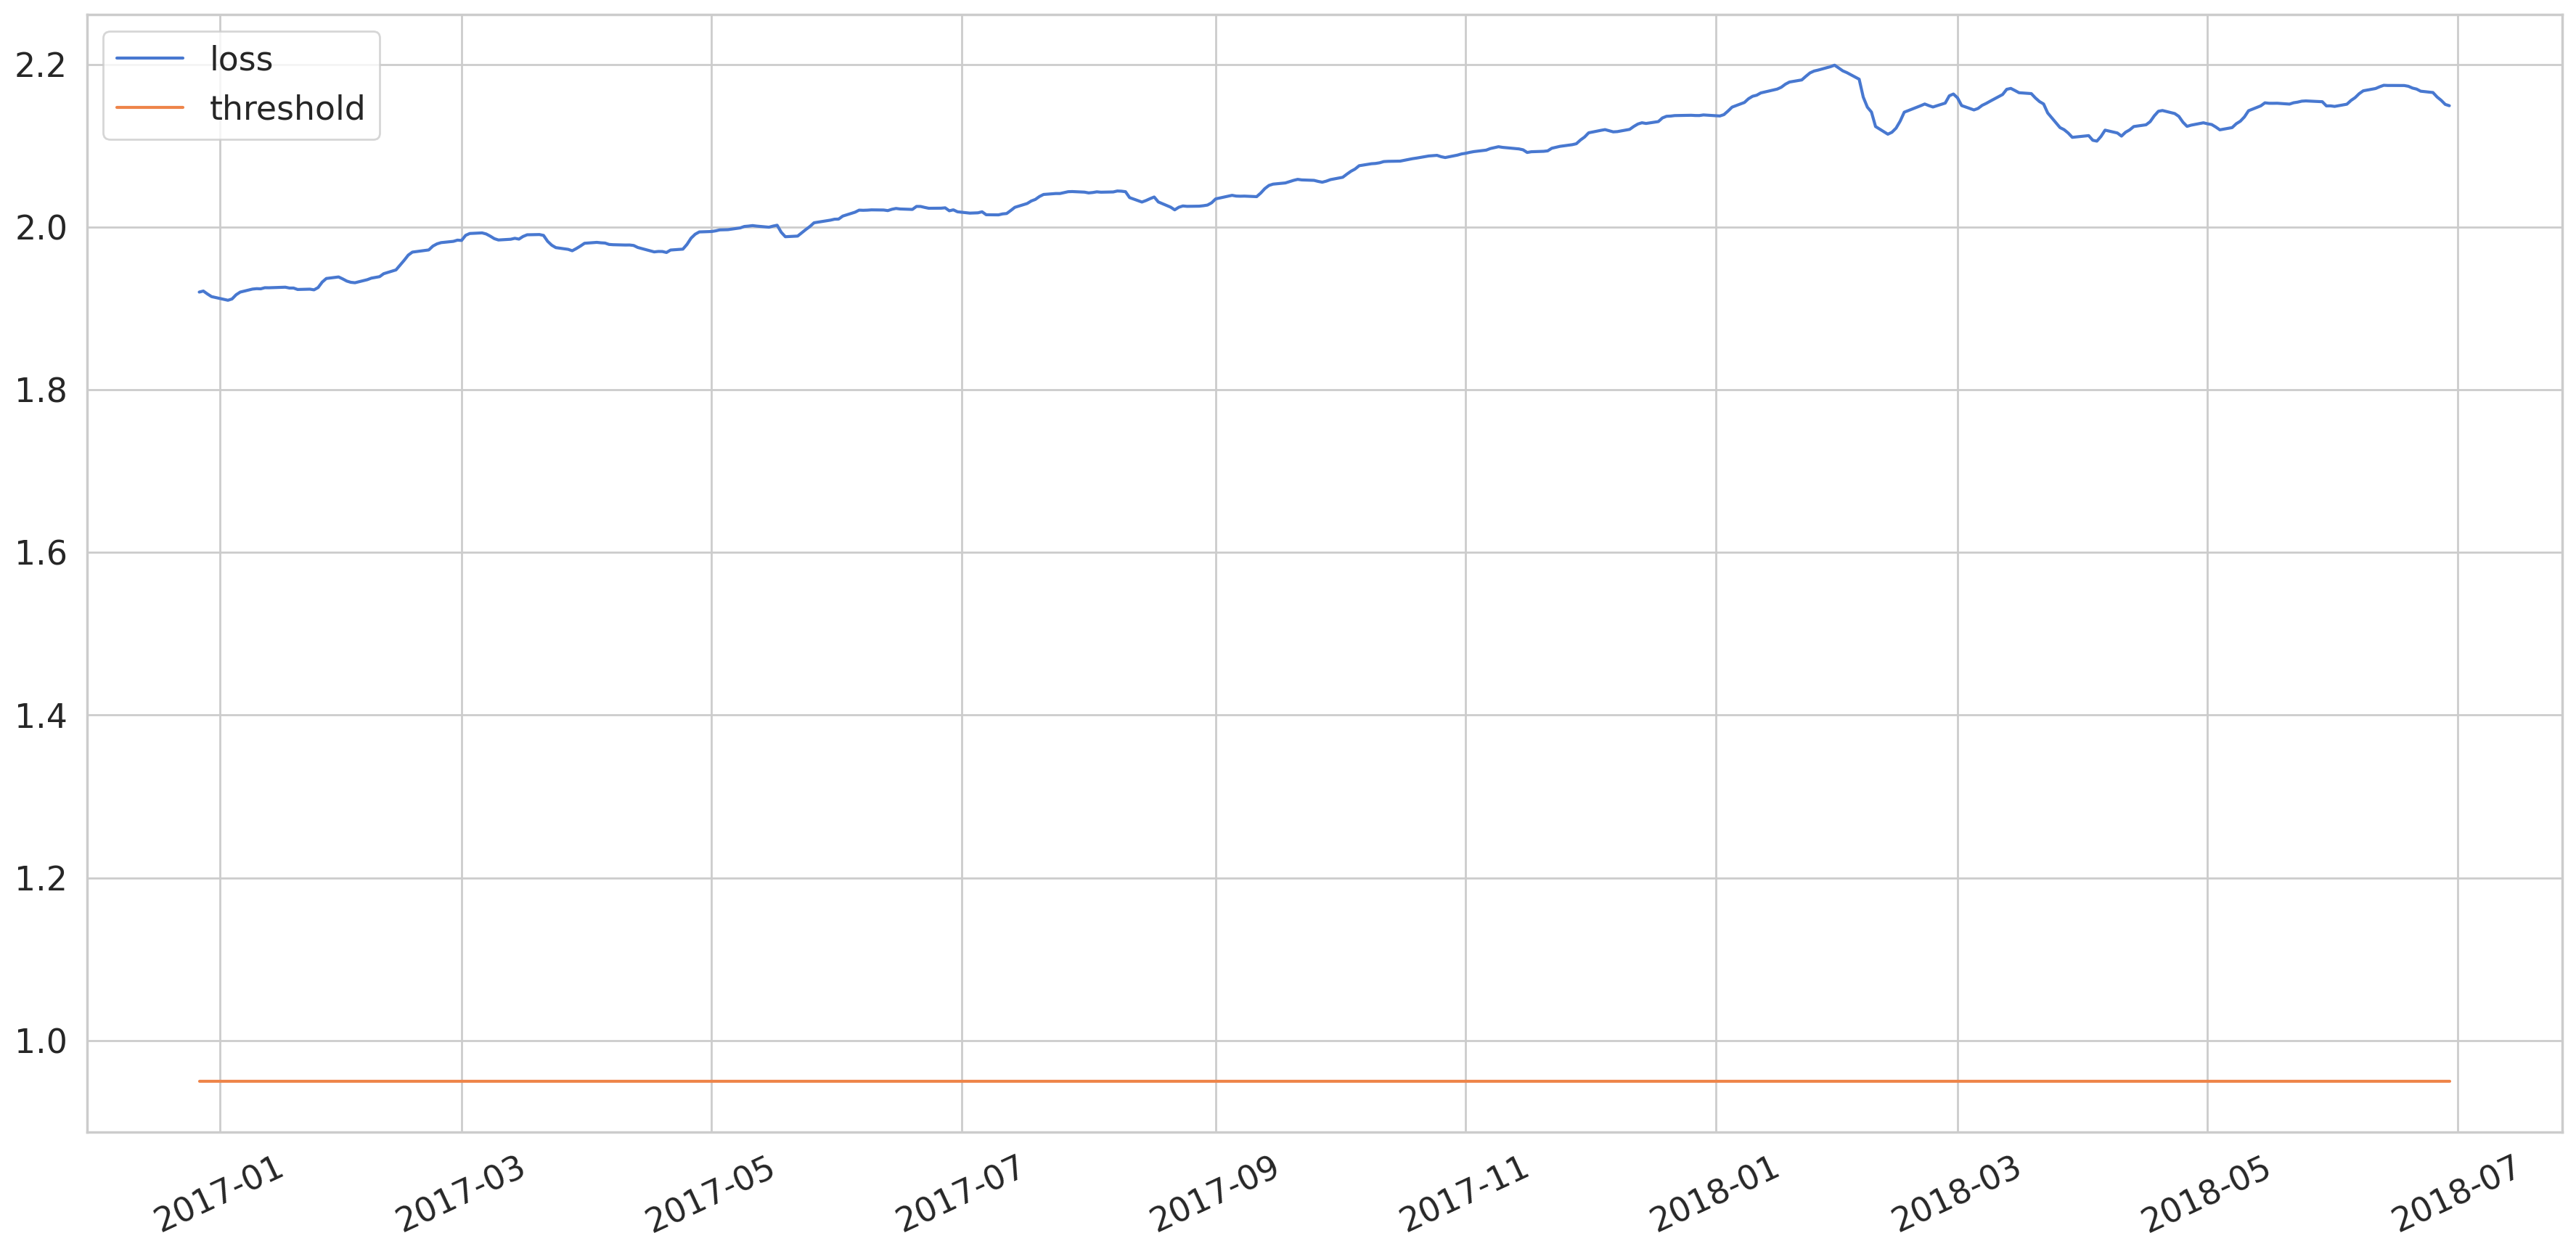

In [28]:
plt.plot(test_score_df.index,test_score_df.loss,label='loss')
plt.plot(test_score_df.index,test_score_df.threshold,label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [29]:
anomalies=test_score_df[test_score_df.anomaly==True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2016-12-27,1.919969,0.95,True,2.392816
2016-12-28,1.921238,0.95,True,2.357204
2016-12-29,1.917625,0.95,True,2.355964
2016-12-30,1.914376,0.95,True,2.336373
2017-01-03,1.909890,0.95,True,2.372061


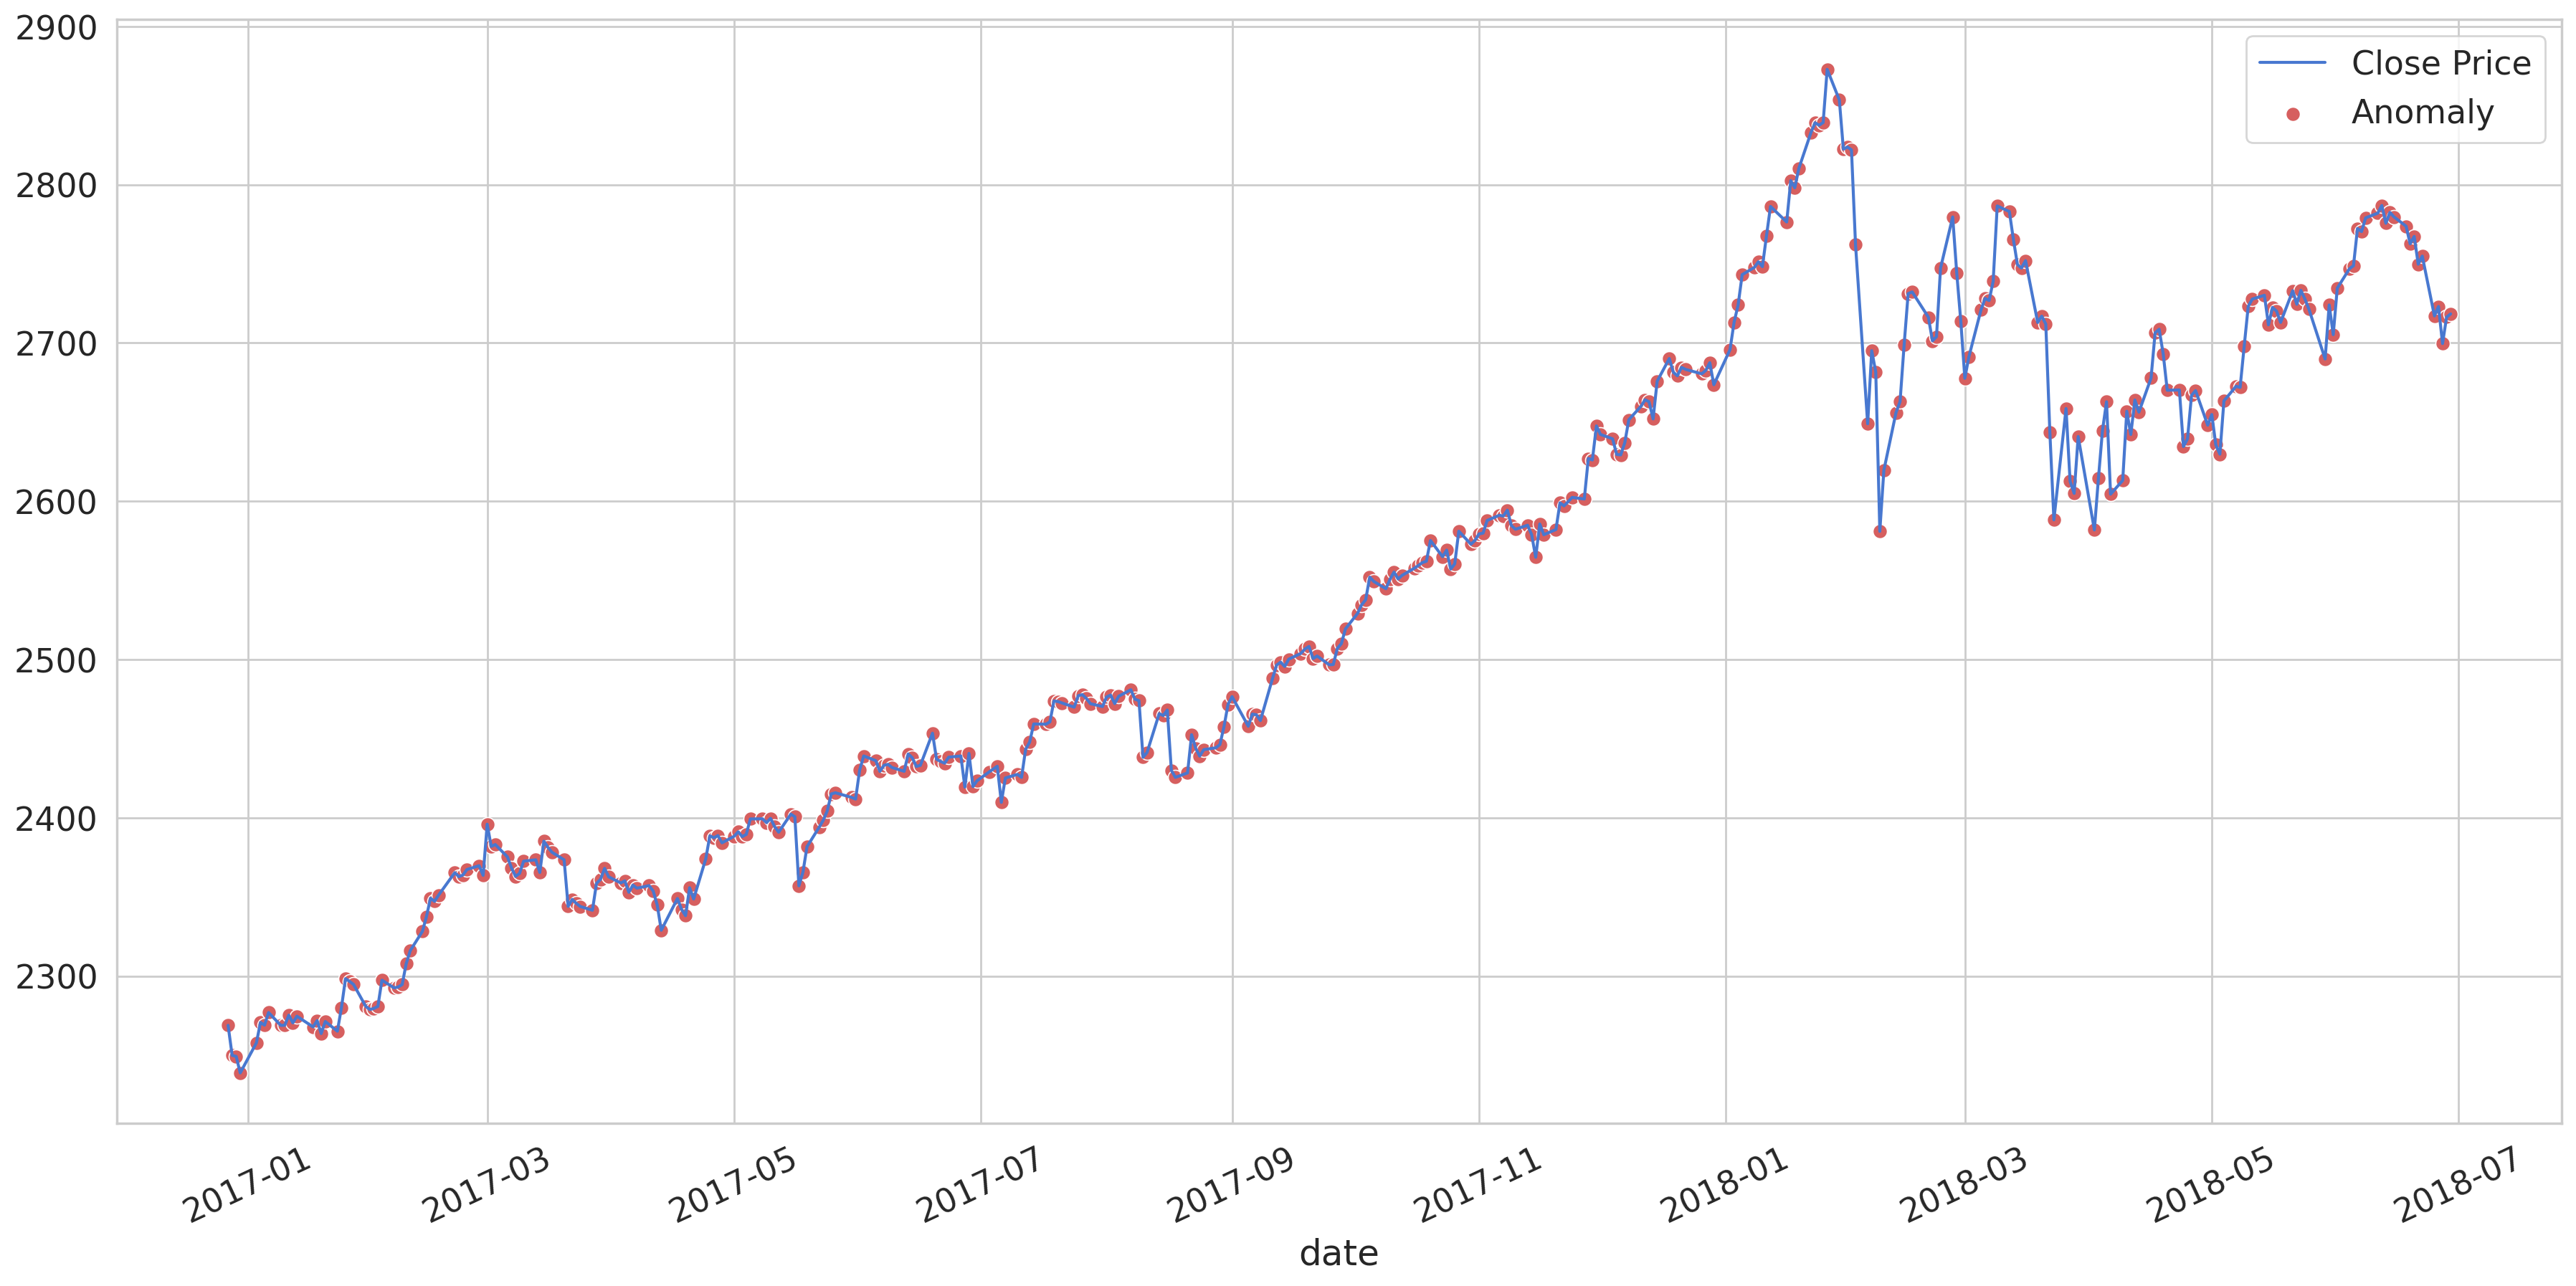

In [30]:
plt.plot(
    test[TIME_STEPS:].index,
    scaler.inverse_transform(test[TIME_STEPS:].close.values.reshape(1,-1)).reshape(-1),
    label='Close Price'
);

sns.scatterplot(
    x=anomalies.index,
    y=scaler.inverse_transform(anomalies.close.values.reshape(1,-1)).reshape(-1),
    color=sns.color_palette()[3],
    s=52,
    label='Anomaly'
)
plt.xticks(rotation=25)
plt.legend();

In [31]:
import pickle